In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,  
    shuffle_files=True, 
    with_info=True,
)

#### 에러 해결
기존 코드로 진행했을 경우, dict 형태로 받았지만 `as_supervised=True`일 경우 튜플 형태로 받는다. 

In [4]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


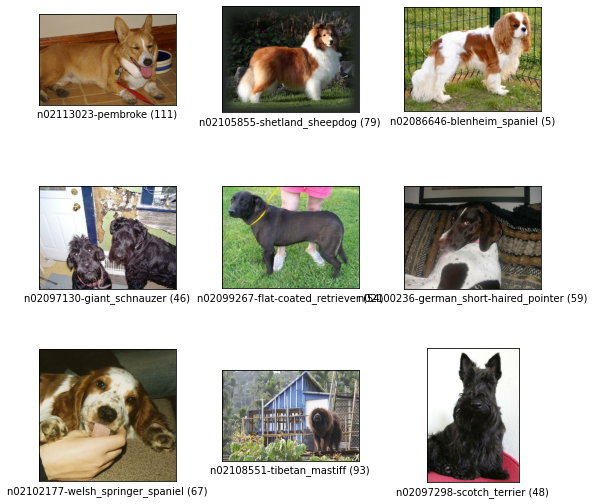

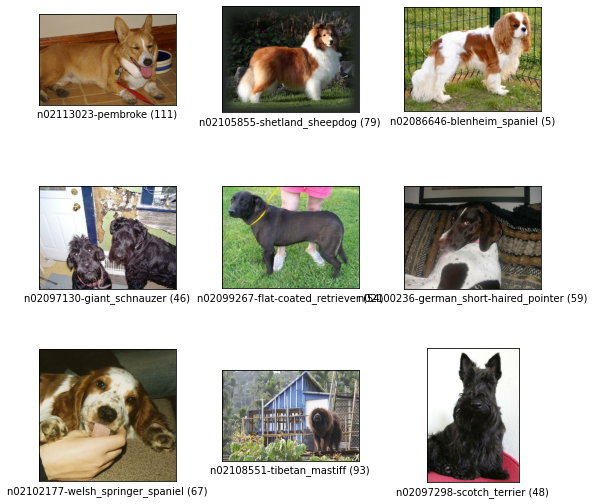

In [5]:
tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [6]:
## 이미지 사이즈 조정 및 정규화
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [25]:
## 데이터 증강 함수1
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

## 데이터 증강 함수2
def augment2(image,label):
    # 랜덤 좌우 반전
    image = tf.image.random_flip_left_right(image)
    
    # 랜덤 상하 반전
    image = tf.image.random_flip_up_down(image)
    
    # 랜덤 회전 (90도 단위)
    random_rotations = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=random_rotations)
    
    # 랜덤 밝기 조정
    image = tf.image.random_brightness(image, max_delta=0.3)
    
    # 랜덤 대비 조정
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    
    # 랜덤 채도 조정 (컬러 이미지일 경우)
    if image.shape[-1] == 3:  # RGB 이미지일 때만 적용
        image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
        
    # 랜덤 노이즈 추가
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
    image = image + noise
    
    # 값 클리핑 (0~1 사이로 유지)
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

In [26]:
## 라벨 원-핫 인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

#### Cutmix

In [27]:
## 이미지 증강: cutmix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

## mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

## mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [28]:
## Cutmix 함수
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup

In [29]:
## 이미지 증강: mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [30]:
## Mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 전처리 적용

In [31]:
## 전처리 함수들 적용
def apply_normalize_on_dataset(
    ds, 
    is_test=False, 
    batch_size=16, 
    with_aug=False, 
    with_cutmix=False,
    with_mixup=False,
#     aug_func=augment
):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ## test 데이터가 아니면서 aug를 할 데이터 셋
    if not is_test and with_aug:
        ds = ds.map(
            augment2
        )
    ds = ds.batch(batch_size)
    
    ## test 데이터가 아니면서 cutmix 할 데이터 셋
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    ## test 데이터가 아니면서 mixup 할 데이터 셋
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [32]:
num_classes = ds_info.features["label"].num_classes

In [33]:
## No Augmentation
ds_train_original = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False
)

## 기본 Augmentation
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False,
    with_mixup=False,
)

# ## 기본 Augmentation2
# ds_train_aug2 = apply_normalize_on_dataset(
#     ds_train,
#     is_test=False, 
#     with_aug=True,
#     with_cutmix=False, 
#     with_mixup=False,
#     aug_func=augment2
# )

## CutMix만 적용
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=True, 
    with_mixup=False    
)

## 기본 Augmentation + CutMix 적용
ds_train_aug_cutmix = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=True,
    with_mixup=False
)

## Mixup만 적용
ds_train_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=False,
    with_cutmix=False,
    with_mixup=True    
)

## 기본 Augmentation + Mixup 적용
ds_train_aug_mixup = apply_normalize_on_dataset(
    ds_train,
    is_test=False, 
    with_aug=True,
    with_cutmix=False, 
    with_mixup=True
)

## test 셋에 대한 전처리
ds_test = apply_normalize_on_dataset(
    ds_test,
    is_test=True, 
    with_aug=False,
    with_cutmix=False
)

#### 데이터셋
1. No Augmentation
2. 기본 Augmentation
3. 기본 Augmentation2
3. CutMix만 적용
4. 기본 Augmentation + CutMix 적용
5. Mixup만 적용
6. 기본 Augmentation + Mixup 적용

## 2. 모델 만들기

In [34]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [35]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [36]:
resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [37]:
resnet50_aug_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [38]:
resnet50_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


## 3. 모델 훈련하기

In [44]:
EPOCH = 60

In [45]:
import os
# 체크포인트 저장 경로 설정
checkpoint_path = "checkpoints/base-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 정의
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # 모델 가중치만 저장
    save_best_only=True,       # 검증 손실이 가장 낮을 때만 저장
    monitor='val_loss',        # 검증 손실 기준
    mode='min',                # 검증 손실이 가장 낮을 때 저장
    save_freq='epoch',         # 매 epoch 마다 저장
    verbose=1                  # 저장 시 메시지 출력
)

#### 1. No Augmentation 학습

In [42]:
for images, labels in ds_train_original.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [43]:
for images, labels in ds_test.take(1):
    print(images.shape)  # (batch_size, height, width, channels)
    print(labels.shape)  # (batch_size,)

(16, 224, 224, 3)
(16, 120)


In [46]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01)
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_original, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[checkpoint_callback]
)

Epoch 1/60
750/750 [==============================] - 202s 209ms/step - loss: 4.7505 - accuracy: 0.0153 - val_loss: 4.8221 - val_accuracy: 0.0099

Epoch 00001: val_loss improved from inf to 4.82211, saving model to checkpoints/base-cp-0001.ckpt
Epoch 2/60
750/750 [==============================] - 156s 207ms/step - loss: 4.5043 - accuracy: 0.0286 - val_loss: 4.9723 - val_accuracy: 0.0296

Epoch 00002: val_loss did not improve from 4.82211
Epoch 3/60
750/750 [==============================] - 155s 207ms/step - loss: 4.1402 - accuracy: 0.0571 - val_loss: 5.2973 - val_accuracy: 0.0364

Epoch 00003: val_loss did not improve from 4.82211
Epoch 4/60
750/750 [==============================] - 156s 207ms/step - loss: 3.7864 - accuracy: 0.1016 - val_loss: 4.1800 - val_accuracy: 0.0735

Epoch 00004: val_loss improved from 4.82211 to 4.18003, saving model to checkpoints/base-cp-0004.ckpt
Epoch 5/60
750/750 [==============================] - 156s 208ms/step - loss: 3.3793 - accuracy: 0.1638 - val_

In [47]:
import pickle

with open("history_resnet50_epoch60.pkl", "wb") as f:
    pickle.dump(history_resnet50.history, f)

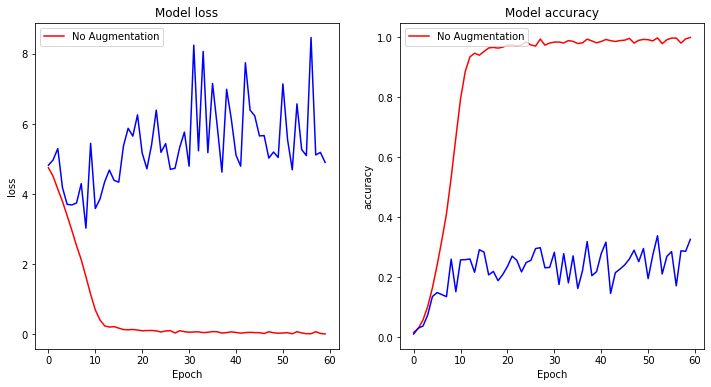

In [51]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_resnet50.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_resnet50.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation'], loc='upper left')
plt.show()

#### 2. 기본 Augmentation 학습

In [52]:
# 체크포인트 저장 경로 설정
checkpoint_path = "checkpoints/aug-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 체크포인트 콜백 정의
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,    # 모델 가중치만 저장
    save_best_only=True,       # 검증 손실이 가장 낮을 때만 저장
    monitor='val_loss',        # 검증 손실 기준
    mode='min',                # 검증 손실이 가장 낮을 때 저장
    save_freq='epoch',         # 매 epoch 마다 저장
    verbose=1                  # 저장 시 메시지 출력
)

In [53]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/60
750/750 [==============================] - 174s 208ms/step - loss: 4.8385 - accuracy: 0.0100 - val_loss: 4.8541 - val_accuracy: 0.0127
Epoch 2/60
750/750 [==============================] - 155s 207ms/step - loss: 4.6869 - accuracy: 0.0188 - val_loss: 4.6501 - val_accuracy: 0.0203
Epoch 3/60
750/750 [==============================] - 155s 207ms/step - loss: 4.4812 - accuracy: 0.0322 - val_loss: 4.4655 - val_accuracy: 0.0358
Epoch 4/60
750/750 [==============================] - 155s 207ms/step - loss: 4.2852 - accuracy: 0.0487 - val_loss: 4.4483 - val_accuracy: 0.0330
Epoch 5/60
750/750 [==============================] - 155s 207ms/step - loss: 4.1199 - accuracy: 0.0632 - val_loss: 4.9161 - val_accuracy: 0.0462
Epoch 6/60
750/750 [==============================] - 155s 207ms/step - loss: 3.9519 - accuracy: 0.0843 - val_loss: 4.2431 - val_accuracy: 0.0746
Epoch 7/60
750/750 [==============================] - 155s 207ms/step - loss: 3.8136 - accuracy: 0.0977 - val_loss: 4.5071 -

In [54]:
with open("history_resnet50_aug_epoch60.pkl", "wb") as f:
    pickle.dump(history_resnet50_aug.history, f)

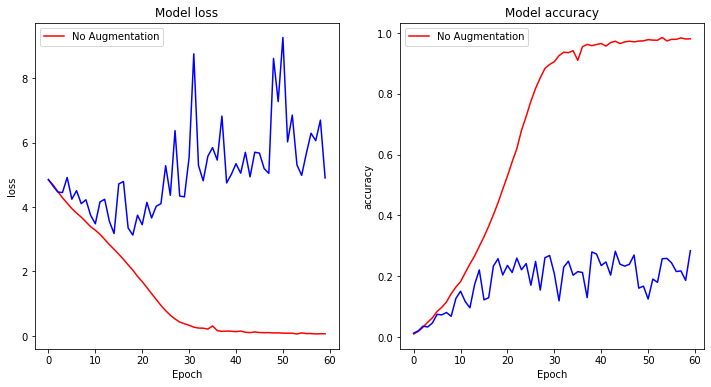

In [55]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_resnet50_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Augmentation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet50_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentation'], loc='upper left')
plt.show()

#### 3. aug + CutMix 적용

In [56]:
resnet50_aug_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/60
750/750 [==============================] - 176s 211ms/step - loss: 4.8372 - accuracy: 0.0075 - val_loss: 4.9268 - val_accuracy: 0.0048
Epoch 2/60
750/750 [==============================] - 156s 208ms/step - loss: 4.7876 - accuracy: 0.0107 - val_loss: 4.8342 - val_accuracy: 0.0085
Epoch 3/60
750/750 [==============================] - 156s 208ms/step - loss: 4.7472 - accuracy: 0.0112 - val_loss: 4.7003 - val_accuracy: 0.0131
Epoch 4/60
750/750 [==============================] - 156s 209ms/step - loss: 4.7174 - accuracy: 0.0128 - val_loss: 4.6471 - val_accuracy: 0.0146
Epoch 5/60
750/750 [==============================] - 156s 208ms/step - loss: 4.7142 - accuracy: 0.0150 - val_loss: 4.6773 - val_accuracy: 0.0129
Epoch 6/60
750/750 [==============================] - 156s 208ms/step - loss: 4.6992 - accuracy: 0.0143 - val_loss: 5.9905 - val_accuracy: 0.0129
Epoch 7/60
750/750 [==============================] - 156s 208ms/step - loss: 4.6878 - accuracy: 0.0169 - val_loss: 4.8081 -

In [57]:
with open("history_resnet50_aug_cutmix_epoch60.pkl", "wb") as f:
    pickle.dump(history_resnet50_aug_cutmix.history, f)

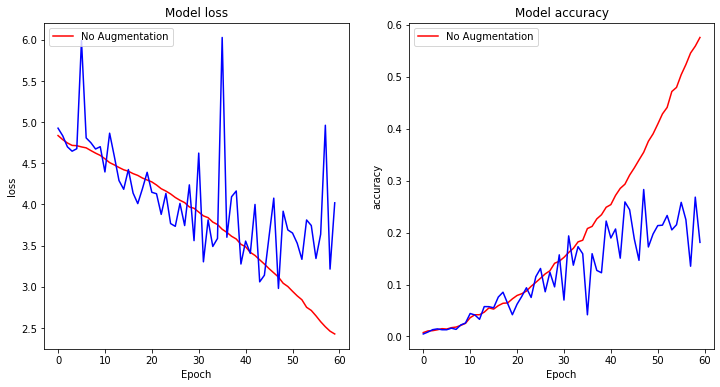

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Augmentation + Cutmix'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentation + Cutmix'], loc='upper left')
plt.show()

기본 augment 와 cutmix를 함께 입력한 모델은 에폭이 60이어도 수렴하지 못한 것 같다.  
optimizer로 adam을 사용해서 그런가? (다른 그루들과의 차이는 optimizer뿐인 것 같은데..)  

#### 4. aug + Mixup 적용

In [59]:
resnet50_aug_mixup.compile(
    loss='categorical_crossentropy',
    optimizer='adam', ## tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = resnet50_aug_mixup.fit(
    ds_train_aug_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/60
750/750 [==============================] - 176s 211ms/step - loss: 4.8397 - accuracy: 0.0075 - val_loss: 5.9589 - val_accuracy: 0.0059
Epoch 2/60
750/750 [==============================] - 157s 209ms/step - loss: 4.7617 - accuracy: 0.0133 - val_loss: 7.6180 - val_accuracy: 0.0138
Epoch 3/60
750/750 [==============================] - 172s 229ms/step - loss: 4.7180 - accuracy: 0.0134 - val_loss: 7.3541 - val_accuracy: 0.0136
Epoch 4/60
750/750 [==============================] - 172s 229ms/step - loss: 4.6998 - accuracy: 0.0166 - val_loss: 4.6415 - val_accuracy: 0.0156
Epoch 5/60
750/750 [==============================] - 157s 209ms/step - loss: 4.6594 - accuracy: 0.0170 - val_loss: 4.5623 - val_accuracy: 0.0261
Epoch 6/60
750/750 [==============================] - 157s 209ms/step - loss: 4.6196 - accuracy: 0.0258 - val_loss: 4.7142 - val_accuracy: 0.0308
Epoch 7/60
750/750 [==============================] - 157s 209ms/step - loss: 4.5767 - accuracy: 0.0260 - val_loss: 4.7289 -

In [60]:
with open("history_resnet50_aug_mixup_epoch60.pkl", "wb") as f:
    pickle.dump(history_resnet50_aug_mixup.history, f)

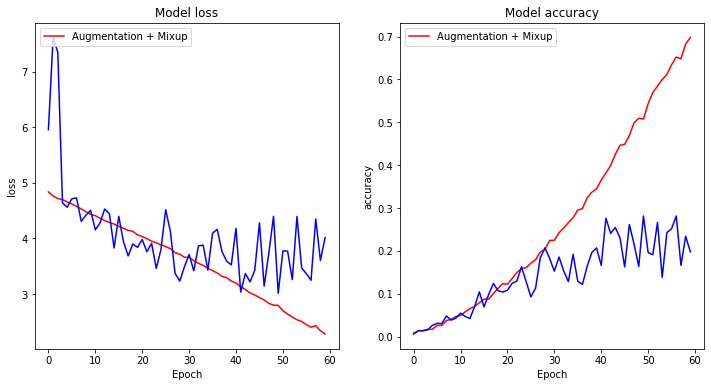

In [61]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_resnet50_aug_mixup.history['loss'], 'r')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Augmentation + Mixup'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'r')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Augmentation + Mixup'], loc='upper left')
plt.show()

augment + mixup 도 여전히 loss가 떨어지고 있다. 

| method      | loss   | accuracy | val_loss | val_accuracy |
| ----------  | ------ | -------- | -------- | ------------ |
| no aug      | 0.0998 | 0.9736   | 3.7353   | 0.2938       |
| only aug    | 0.1894 | 0.9459   | 3.0032   | 0.3372       |
| only cutmix | 2.3892 | 0.5928   | 3.1091   | 0.2726       |
| only mixup  | 3.0657 | 0.4287   | 3.5353   | 0.1799       |

## 4. 훈련 과정 시각화하기

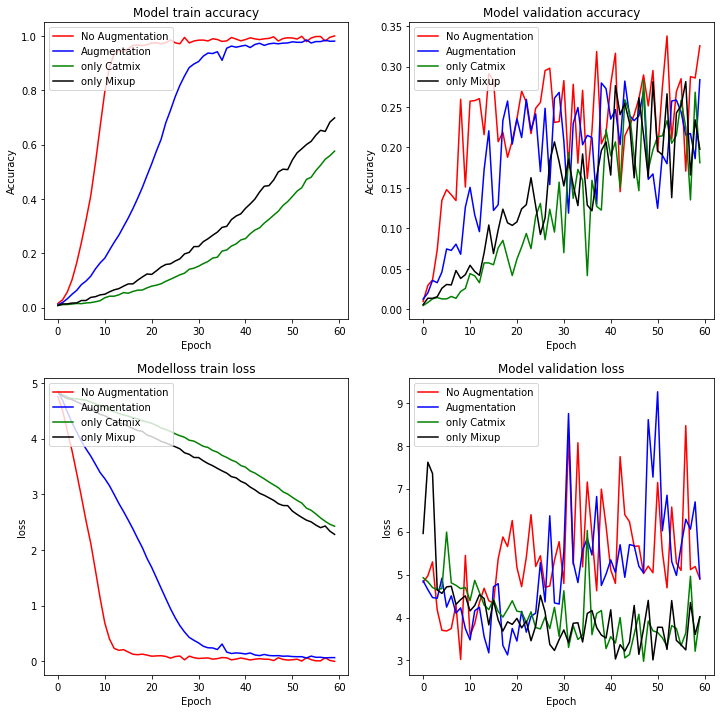

In [62]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(history_resnet50.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'black')

plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'black')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,3)
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'black')

plt.title('Modelloss train loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')

plt.subplot(2,2,4)
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'black')

plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'only Catmix', 'only Mixup'], loc='upper left')
plt.show()

에폭을 20에서 60으로 늘렸음에도 불구하고 catmix 와 mixup의 train acc와 loss를 확인해본 결과 아직 충분히 학습이 되지 않았다고 생각된다. 
학습률에 신경을 더 써봐야겠다.  